In [4]:
# Import libraries
import sys
import ete3
import os
from os import walk
sys.path.insert(0,'../scripts/')
from classDeclarationsAndFunctions import RootedTree
from fileIO import ReadRootedTree
from MarkovModels import GenerateQForStationaryDistribution, Get11FreeRates
from math import floor, ceil
from config import projectPath
import matplotlib.pyplot as plt
import numpy as np
from math import log

In [2]:
# Job scripts
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
num_trees_simulated = 0 
for seq_len in [1000,2000,5000,10000]:
    iqtree_script = open("../batch_scripts/iqtree_scalability_"+str(seq_len)+".sh","w")
    mstbackbone_script = open("../batch_scripts/mstbackbone_scalability_"+str(seq_len)+".sh","w")
    fasttree_script = open("../batch_scripts/fastree_scalability_"+str(seq_len)+".sh","w")
    raxml_script = open("../batch_scripts/raxml_scalability_"+str(seq_len)+".sh","w")    
    tree_id_num_leaves_scalability_file = open("../data/selected_grove_tree_ids_scalability","r")
    for line in tree_id_num_leaves_scalability_file:        
        tree_id = line.strip().split(',')[0].strip()
        num_leaves = int(line.strip().split(',')[1].strip())
        num_trees_simulated += 1
        print("Writing batch commands for tree ", str(num_trees_simulated))    
        mxqsub_prefix = ""
        exp_id = "treeId_"+tree_id+"_numLeaves_"+str(num_leaves)+"_seqLen_"+str(seq_len)
        exp_dir = data_path + "grove_exp/" + exp_id
        sequence_file_name = exp_dir + "/sequences_"+exp_id+".fas"                
        ###############        IQ-TREE      ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N iqtree_scale\t"
        # mxqsub_prefix += " --stderr=err_iqtree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_iqtree_scalability_"+exp_id
        iqtree_command = tools_path_geniux + "iqtree2"
        iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
        iqtree_command += ' -nt ' + str(1)
        iqtree_command += ' -seed 1234'
        # iqtreeCommand += ' -quiet'
        iqtree_command += ' -redo'
        iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
        iqtree_command += ' -m 12.12+FO'
        iqtree_script.write(mxqsub_prefix + iqtree_command + "\n")
        ###############     MST-BACKBONE     ###################
        # mst_backbone_command
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N mstbackbone_scale\t"
        # mxqsub_prefix += " --stderr=err_mstbackbone_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_mstbackbone_scalability_" + exp_id
        mst_backbone_command = tools_path_geniux + "mst-backbone"
        mst_backbone_command += '\t--seq ' + sequence_file_name
        mst_backbone_command += '\t--out ' + exp_id
        mstbackbone_script.write(mxqsub_prefix + mst_backbone_command + "\n")
        ###############        RAxML-NG       ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N raxmlng_scale\t"
        # mxqsub_prefix += " --stderr=err_raxmlng_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_raxmlng_scalability_" + exp_id
        raxml_command = tools_path_geniux + "raxml-ng"
        fileNamePrefix = 'RAxMLNG_' + exp_id
        raxml_command += ' --tree pars{1}'
        raxml_command += ' --model GTR --msa ' + sequence_file_name
        raxml_command += ' --threads 1'
        # raxml_command += ' --redo '
        raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
        raxml_command += ' --prefix ' + fileNamePrefix
        raxml_script.write(mxqsub_prefix + raxml_command + "\n")
        #############          FastTree        ################
        # mxqsub_prefix = ""
        # mxqsub_prefix = "mxqsub -t 2d -m 1G -n -N fasttree_scale\t"
        # mxqsub_prefix += " --stderr=err_fasttree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_fasttree_scalability_"+exp_id
        output_tree_file_name = sequence_file_name + '.fasttree_newick'
        std_err_file_name = sequence_file_name + '.fasttree_errlog'
        fasttree_command = tools_path_geniux + 'FastTree'
        fasttree_command += ' -nt -nosupport -nocat -gtr < '+ sequence_file_name
        fasttree_command += ' > ' + output_tree_file_name
        fasttree_command += ' 2> ' + std_err_file_name
        fasttree_script.write(mxqsub_prefix + fasttree_command + "\n")
        ########################################################
    tree_id_num_leaves_scalability_file.close()
    raxml_script.close()
    fasttree_script.close()
    mstbackbone_script.close()
    iqtree_script.close()

FileNotFoundError: [Errno 2] No such file or directory: '../batch_scripts/iqtree_scalability_1000.sh'

In [3]:
# results list (count num of results)
run_time_num_taxa = {}
run_time_seq_length = {}
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
def Check_results_file_names(method,exp_id):
    exp_dir = data_path + "grove_exp/" + exp_id
    sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
    if method == "raxmlng":
        log_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        tree_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree'
    elif method.startswith("mstbackbone"):
        # log_file_name = projectPath + '/batch_scripts/' + exp_id + '.mstbackbone_log'
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'
    if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
        if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
            return(True)
        else:
            return(False)
    else:
        return(False)

num_results = {}
for method in method_list:
    num_results[method] = 0

tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    # num_trees_simulated += 1    
    for seq_len in seqlen_list:
        for method in method_list:            
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                num_results[method] += 1

tree_id_num_leaves_scalability_file.close()

for method in method_list:
    print (num_results[method], "results available for ", method)
            # exp_dir = data_path + "grove_exp/" + exp_id
            # sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
            
            
            

460 results available for  fasttree
458 results available for  iqtree
180 results available for  mstbackbone
420 results available for  raxmlng


In [4]:
# Store run times
method_list = ['fasttree','iqtree','mstbackbone_unrooted','mstbackbone_rooted','raxmlng']

def Get_run_time(method,exp_id):
    # print(method, exp_id)
    runTime = -1
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Elapsed time:'):
                runTime = float(line.strip().split('Elapsed time:')[1].split(' seconds')[0])                
    elif method == "mstbackbone_unrooted":        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('CPU time used for computing global unrooted phylogenetic tree T is '):
                runTime = float(line.split('CPU time used for computing global unrooted phylogenetic tree T is ')[1].split(' second(s)')[0])
    elif method == "mstbackbone_rooted":        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('CPU time used for rooting T using restriced SEM is '):
                runTime = float(line.split('CPU time used for rooting T using restriced SEM is ')[1].split(' second(s)')[0])
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total time: '):
                runTime = float(line.strip().split('Total time: ')[1].split(' seconds')[0])
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used:'):
                runTime = float(line.split('Total CPU time used: ')[1].split(' sec')[0])
    log_file.close()
    return (runTime)

run_times_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
for seq_len in seqlen_list:
    run_times_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    for method in method_list: 
        run_times_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []        
        tree_id_seq_len_method[seq_len][method] = []

num_leaves_list = []
results_path = projectPath + "results/"
run_time_grove_file = open(results_path + "run_time_grove","w")
run_time_grove_file.write('run_time, seq_len, num_leaves, method, tree_id\n')
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                run_time = Get_run_time(method,exp_id)
                if (run_time > 0) :
                    run_times_seq_len_method[seq_len][method].append(run_time)
                    num_leaves_seq_len_method[seq_len][method].append(num_leaves)
                    tree_id_seq_len_method[seq_len][method].append(tree_id)                                       
                    run_time_grove_file.write(str(run_time) + ", " + str(seq_len) + "," + str(num_leaves) + ", " + method + ", " + str(tree_id) + "\n")

tree_id_num_leaves_scalability_file.close()
run_time_grove_file.close()

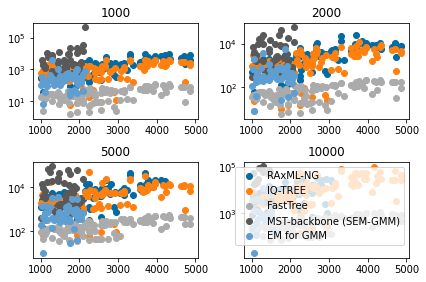

In [5]:
# Plot run times

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

# Fixing random state for reproducibility

fig, ax = plt.subplots(2,2)
i = 0
seq_len = 1000

# method_list = ['fasttree', 'mstbackbone']
method_list = ['raxmlng','iqtree','fasttree','mstbackbone_unrooted','mstbackbone_rooted']
for method in method_list:
    for seq_len in seqlen_list:    
        # if method == 'fasttree':
        if seq_len == 1000:
            # ax_fast.subplot(2, 2, i)    
            ax[0, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)
            ax[0, 0].set_title(seq_len)
            # ax[0, 0].set_xscale("log")
            ax[0, 0].set_yscale("log")
        # elif method == 'mstbackbone':
        elif seq_len == 2000:
            # ax_mstbackbone.subplot(2, 2, i)    
            ax[0, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)            
            ax[0, 1].set_title(seq_len)
            # ax[0, 1].set_xscale("log")
            ax[0, 1].set_yscale("log")
        # elif method == 'raxmlng':
        elif seq_len == 5000:
            # ax_raxml.subplot(2, 2, i)    
            ax[1, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)
            ax[1, 0].set_title(seq_len)
            # ax[1, 0].set_xscale("log")
            ax[1, 0].set_yscale("log")
        # elif method == 'iqtree':
        elif seq_len == 10000:
            # ax_iqtree.plot(2, 2, i) 
            ax[1, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method)
            ax[1, 1].set_title(seq_len)
            # ax[1, 1].set_xscale("log")
            ax[1, 1].set_yscale("log")
# ax.set_yscale("log")
fig.tight_layout(pad=1.0)
plt.legend(['RAxML-NG', 'IQ-TREE', 'FastTree','MST-backbone (SEM-GMM)','EM for GMM'], loc ="upper right")
plt.show()
# plt.show()



In [7]:
# Store (Precision, Recall, RF) x (Rooted, Unrooted) x (FastTree, MST-backbone, RAxML-NG, IQ-TREE) x (1000, 2000, 5000, 10000)

from metrics import ComputePrecisionRecallAndRFGivenSplits, ComputePrecisionRecallAndRFforNonTrivialClusters, ComputePrecisionRecallAndRFforRootedTrees
from fileIO import ReadTree
data_path = projectPath + "data/"

def Get_accuracy(method,exp_id):    
    pr_rooted, re_rooted, rf_rooted = -1, -1, -1
    pr_unrooted, re_unrooted, rf_unrooted = -1, -1, -1
    tree_id = exp_id.split('_numLeaves_')[0].split('treeId_')[1]
    model_tree_file_name = data_path + 'RAxMLGrove/trees/' + tree_id + '/tree_best.newick'
    RT_model = ReadRootedTree(model_tree_file_name,"newick")
    splits_model = RT_model.GetAllNonTrivialSplits()
    if method == "raxmlng":
        tree_type = "unrooted"
        estimated_tree_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree' 
    elif method == "fasttree":
        tree_type = "unrooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'       
    elif method == "mstbackbone":
        tree_type = "rooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "iqtree":
        tree_type = "rooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'
    if tree_type == "rooted":
        RT_estimated = ReadRootedTree(estimated_tree_file_name, 'newick')
        pr_rooted, re_rooted, rf_rooted = ComputePrecisionRecallAndRFforRootedTrees(RT_model, RT_estimated)       
    elif tree_type == "unrooted":
        T_estimated = ReadTree(estimated_tree_file_name, 'newick')
        u_name, v_name = list(T_estimated.edgeLengths.keys())[0]
        t = T_estimated.GetEdgeLength(u_name, v_name)
        RT_estimated = T_estimated.GetRootedTree(u_name, v_name, t/2.0, t/2.0)    
    splits_estimated = RT_estimated.GetAllNonTrivialSplits()
    pr_unrooted, re_unrooted, rf_unrooted = ComputePrecisionRecallAndRFGivenSplits(splits_model, splits_estimated)
    return ([pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted])

method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
accuracy_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
for seq_len in seqlen_list:
    accuracy_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    for method in method_list:
        accuracy_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []
        tree_id_seq_len_method[seq_len][method] = []        

num_leaves_list = []
accuracy_grove_file = open(results_path + "grove_accuracy_updated","w")
accuracy_grove_file.write("pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves\n")
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
num_trees_processed = 0
for line in tree_id_num_leaves_scalability_file:    
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                accuracy = Get_accuracy(method,exp_id)
                accuracy_seq_len_method[seq_len][method].append(accuracy)
                for acc in accuracy:
                    accuracy_grove_file.write(str(acc) + ",")
                num_leaves_seq_len_method[seq_len][method].append(num_leaves)
                tree_id_seq_len_method[seq_len][method].append(tree_id)
                accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + "," + str(num_leaves) + "\n")
                print (tree_id)
    num_trees_processed += 1    
    print("Finished computing accuracy for ", num_trees_processed, " trees")





accuracy_grove_file.close()
tree_id_num_leaves_scalability_file.close()

/usr/local/bin/Rscript	/home/kalaghat/exaptation/Projects/MSTBasedForests/scripts/parseNewickTree.R	/home/kalaghat/exaptation/Projects/MSTBasedForests/data/grove_exp/treeId_12258_numLeaves_999_seqLen_1000/sequences_treeId_12258_numLeaves_999_seqLen_1000.fas.fasttree_newick	/home/kalaghat/exaptation/Projects/MSTBasedForests/data/grove_exp/treeId_12258_numLeaves_999_seqLen_1000/sequences_treeId_12258_numLeaves_999_seqLen_1000.fas.fasttree_newick.tempTree
/usr/local/bin/Rscript	/home/kalaghat/exaptation/Projects/MSTBasedForests/scripts/parseNewickTree.R	/home/kalaghat/exaptation/Projects/MSTBasedForests/batch_scripts/RAxMLNG_treeId_12258_numLeaves_999_seqLen_1000.raxml.bestTree	/home/kalaghat/exaptation/Projects/MSTBasedForests/batch_scripts/RAxMLNG_treeId_12258_numLeaves_999_seqLen_1000.raxml.bestTree.tempTree
/usr/local/bin/Rscript	/home/kalaghat/exaptation/Projects/MSTBasedForests/scripts/parseNewickTree.R	/home/kalaghat/exaptation/Projects/MSTBasedForests/data/grove_exp/treeId_12258_n

KeyboardInterrupt: 

In [8]:
# Write accuracy to file
results_path = projectPath + "results/"
data_path = projectPath + "data/"
accuracy_grove_file = open(results_path + "grove_accuracy","w")
accuracy_grove_file.write("pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves\n")
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
for seq_len in seqlen_list:
    for method in method_list:
        num_results = len(accuracy_seq_len_method[seq_len][method])
        for i in range(num_results):
            for acc in accuracy_seq_len_method[seq_len][method][i]:
                accuracy_grove_file.write(str(acc) + ",")            
            num_leaves = num_leaves_seq_len_method[seq_len][method][i]
            tree_id = tree_id_seq_len_method[seq_len][method][i]
            accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + ", " + str(num_leaves) + "\n")






accuracy_grove_file.close()


NameError: name 'accuracy_seq_len_method' is not defined

In [10]:
# accuracy_seq_len_method = {}
recall_rooted_seq_len_method = {}
recall_unrooted_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
for seq_len in seqlen_list:
    recall_unrooted_seq_len_method[seq_len] = {}
    recall_rooted_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    for method in method_list:
        recall_unrooted_seq_len_method[seq_len][method] = []
        recall_rooted_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []
        tree_id_seq_len_method[seq_len][method] = []



        
results_path = projectPath + "results/"
data_path = projectPath + "data/"

accuracy_grove_file = open(results_path + "grove_accuracy","r")
accuracy_grove_file.readline()
for res in accuracy_grove_file:
    pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves = res.split(",")    
    seq_len = int(seq_len)
    num_leaves = int(num_leaves)    
    recall_unrooted_seq_len_method[seq_len][method].append(float(re_unrooted))
    recall_rooted_seq_len_method[seq_len][method].append(float(re_rooted))
    num_leaves_seq_len_method[seq_len][method].append(int(num_leaves))
    tree_id_seq_len_method[seq_len][method].append(tree_id)


accuracy_grove_file.close()


In [11]:
results_path = projectPath + "results/"
data_path = projectPath + "data/"
import pandas as pd
accuracy_grove = pd.read_csv(results_path + "grove_accuracy")
accuracy_grove.rename(columns=lambda x: x.strip(),inplace=True)

# print(accuracy_grove.keys())
accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == 1000]
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['re_unrooted'])
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['tree_id'])
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['seq_len'])
# recall_unrooted_seq_len_method[seq_len]

0      0.596386
1      0.664799
2      0.830591
3      0.021968
4      0.666063
         ...   
110    0.510770
111    0.509595
112    0.018155
113    0.491365
114    0.415638
Name: re_unrooted, Length: 115, dtype: float64
0      12258
1      11413
2      13668
3      19588
4      12132
       ...  
110    24986
111    53458
112    14206
113    15551
114    21337
Name: tree_id, Length: 115, dtype: int64
0      1000
1      1000
2      1000
3      1000
4      1000
       ... 
110    1000
111    1000
112    1000
113    1000
114    1000
Name: seq_len, Length: 115, dtype: int64


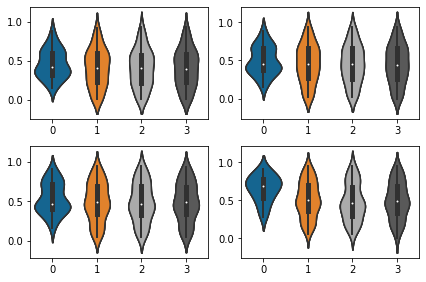

In [12]:
# Plot accuracy
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

fig, ax = plt.subplots(2,2)
i = 0
seq_len = 1000
pos_method = {}
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
# pos_method['mstbackbone'] = 1 
# pos_method['fasttree'] = 2
# pos_method['raxmlng'] = 3
# pos_method['iqtree'] = 4
pos = [1,2,3,4]

recall_unrooted_list = {}
for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    recall_unrooted_list[seq_len] = []
    for method in method_list:
        recall_unrooted_list[seq_len].append(accuracy_seq_len[accuracy_seq_len['method'] == method]['re_unrooted'])

for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    for method in method_list:
        if seq_len == 1000:
            # ax[0, 0].violinplot(recall_unrooted_list[seq_len], pos)
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,0])
            # ax[0, 0].set_title(seq_len)
            # ax[0, 0].set_yscale("log")
        elif seq_len == 2000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,1])
            # ax[0, 1].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[0, 1].set_title(seq_len)
            # ax[0, 1].set_yscale("log")
        elif seq_len == 5000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,0])
            # ax[1, 0].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])
            # ax[1, 0].set_yscale("log")
        elif seq_len == 10000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])
            # ax[1, 1].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 1].set_title(seq_len)
            # ax[1, 1].set_yscale("log")
fig.tight_layout(pad=1.0)
# labels = ['A', 'B', 'C', 'D']
# plt.legend(method_list, loc ="upper right")
# plt.xlabel(method_list)
plt.show()

In [11]:
# Scatter plot wrt mst-backbone (SEM-GM)

import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

fig, ax = plt.subplots(1,3)
i = 0
seq_len = 1000
pos_method = {}
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']

pos = [1,2,3,4]

recall_unrooted_list = {}
for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    recall_unrooted_list[seq_len] = []
    for method in method_list:
        recall_unrooted_list[seq_len].append(accuracy_seq_len[accuracy_seq_len['method'] == method]['re_unrooted'])


In [ ]:
# Quartet-based analysis

